In [334]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F

import math
import time
import skrf as rf

import VF.vectorfit as vectorfit
import os

In [335]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


# Load the data

In [336]:
root_path = "/scratch/cluster/vgorti/UTAFSDataNew/new_data"
chip_num = 21

In [337]:
import utils

data_dict = utils.grab_chip_data(root_path, chip_num, resample=False)

In [338]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Check the data matrices converted from touchstone to np

In [339]:
print("GT Data shape: ", data_dict['gt_matrix'].shape)
print("VF Data shape: ", data_dict['vf_matrix'].shape)
print("Y Data shape: ", data_dict['y_matrix'].shape)

GT Data shape:  (600, 2, 2, 2)
VF Data shape:  (600, 2, 2, 2)
Y Data shape:  (11, 2, 2, 2)


In [340]:
print("GT Data type: ", data_dict['gt_matrix'].dtype)
print("VF Data type: ", data_dict['vf_matrix'].dtype)
print("Y Data type: ", data_dict['y_matrix'].dtype)

GT Data type:  float32
VF Data type:  float32
Y Data type:  float32


In [341]:
print("GT frequency shape: ", data_dict['gt_freqs'].shape)
print("Y frequency shape: ", data_dict['y_freqs'].shape)

GT frequency shape:  (600,)
Y frequency shape:  (11,)


In [342]:
print("GT frequency type: ", data_dict['gt_freqs'].dtype)
print("Y frequency type: ", data_dict['y_freqs'].dtype)

GT frequency type:  float64
Y frequency type:  float64


## Calc the Singular values to check the distribution

In [343]:
temp = np.empty(data_dict['gt_matrix'].shape[:-1], dtype=np.complex64)
temp.real = data_dict['gt_matrix'][..., 0]
temp.imag = data_dict['gt_matrix'][..., 1]

print("Complex GT data shape: ", temp.shape)
print("Complex GT data type: ", temp.dtype)

Complex GT data shape:  (600, 2, 2)
Complex GT data type:  complex64


In [344]:
vals = np.linalg.svd(temp, compute_uv=False)
print("GT data singular values shape: ", vals.shape)

GT data singular values shape:  (600, 2)


In [345]:
vals = vals[:,0]
print("GT data largest singular values shape: ", vals.shape)

GT data largest singular values shape:  (600,)


In [346]:
print("Max singular value: ", np.amax(vals))
print("Min singular value: ", np.amin(vals))

Max singular value:  1.0961771
Min singular value:  0.6222802


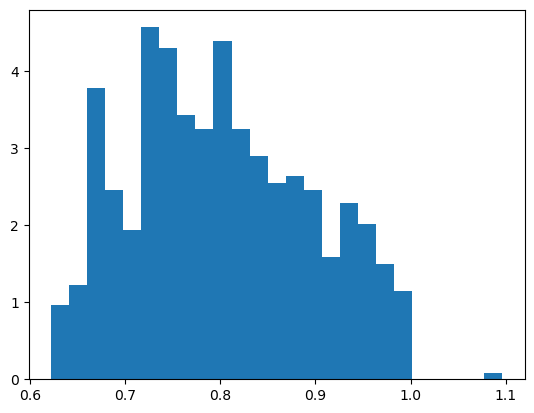

In [347]:
plt.figure()
plt.hist(vals, density=True, bins=25)
plt.show()

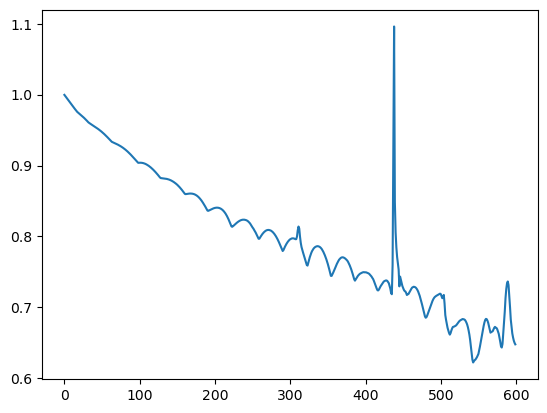

In [348]:
plt.figure()
plt.plot(vals)
plt.show()

## Convert the raw data matrices to only the unique S-parameters

In [349]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

In [350]:
print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (3, 2, 600)
GT S-parameters shape:  (3, 2, 600)
Y S-parameters shape:  (3, 2, 11)


In [351]:
print("VF S-parameters type: ", vf_data.dtype)
print("GT S-parameters type: ", gt_data.dtype)
print("Y S-parameters type: ", y_data.dtype)

VF S-parameters type:  float32
GT S-parameters type:  float32
Y S-parameters type:  float32


In [352]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

In [353]:
print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (600,)
Y frequencies shape:  (11,)


In [354]:
print("GT frequencies type: ", gt_freqs.dtype)
print("Y frequencies type: ", y_freqs.dtype)

GT frequencies type:  float64
Y frequencies type:  float64


## Plot the Ground truth S-parameters 

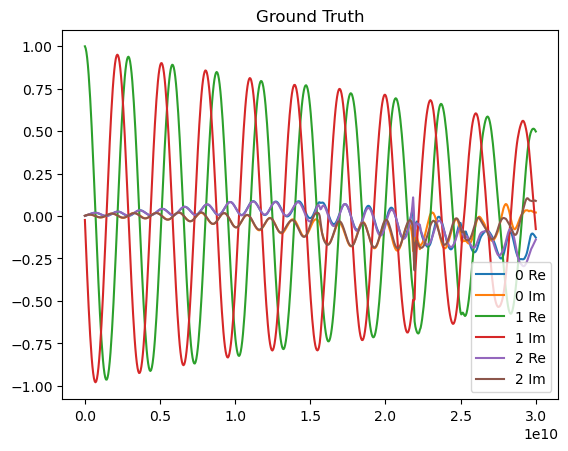

In [355]:
n_sparams = gt_data.shape[0]

plt.figure()
for i in range(n_sparams):
    plt.plot(gt_freqs, gt_data[i,0,:].squeeze(), label=str(i)+" Re")
    plt.plot(gt_freqs, gt_data[i,1,:].squeeze(), label=str(i)+" Im")
if n_sparams <= 10:
    plt.legend()
plt.title("Ground Truth")
plt.show()

In [356]:
gt_mag = utils.to_mag(torch.from_numpy(gt_data))

print("GT magniutde shape: ", gt_mag.shape)

GT magniutde shape:  torch.Size([3, 600])


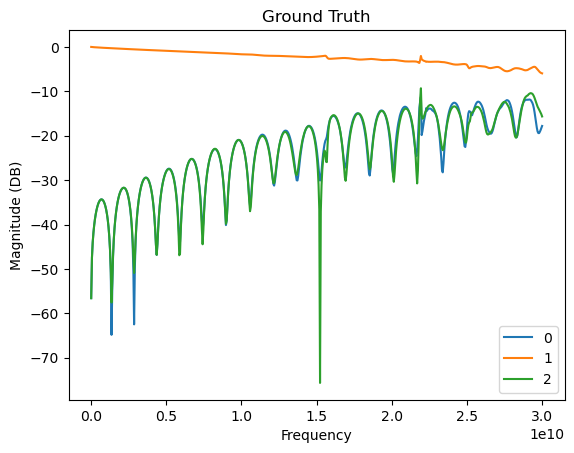

In [357]:
n_sparams = gt_mag.shape[0]

plt.figure()
for i in range(n_sparams):
    plt.plot(gt_freqs, gt_mag[i], label=str(i))
if n_sparams <= 10:
    plt.legend()
plt.title("Ground Truth")
plt.ylabel("Magnitude (DB)")
plt.xlabel("Frequency")
plt.show()

## Check the data for some smoothness and regularity conditions

In [358]:
def calc_diffs(x, order=1):
    if order > 1:
        x = calc_diffs(x, order-1)
    
    if isinstance(x, np.ndarray):
        return (x - np.roll(x, -1, 2))[...,:-1] 
    elif torch.is_tensor(x):
        return (x - torch.roll(x, -1, 2))[...,:-1]

(3, 2, 599)


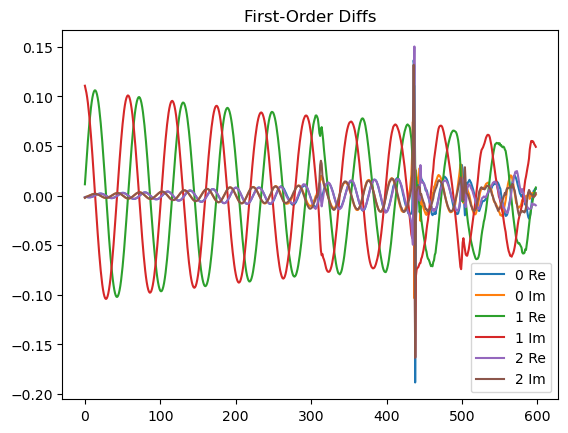

In [359]:
x_diff_1 = calc_diffs(gt_data)

print(x_diff_1.shape)

plt.figure()
for i in range(n_sparams):
    plt.plot(x_diff_1[i,0,:].squeeze(), label=str(i)+" Re")
    plt.plot(x_diff_1[i,1,:].squeeze(), label=str(i)+" Im")
if n_sparams <= 10:
    plt.legend()
plt.title("First-Order Diffs")
plt.show()

(3, 2, 598)


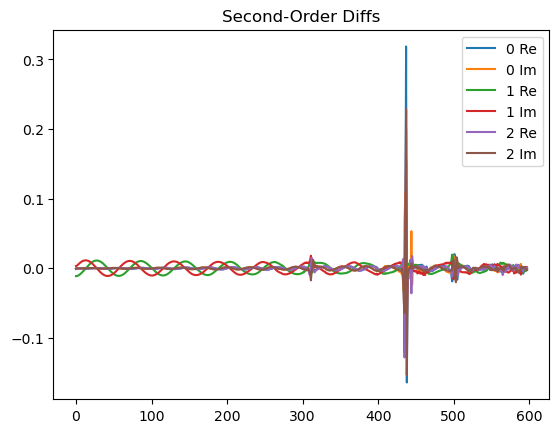

In [360]:
x_diff_2 = calc_diffs(gt_data, 2)

print(x_diff_2.shape)

plt.figure()
for i in range(n_sparams):
    plt.plot(x_diff_2[i,0,:].squeeze(), label=str(i)+" Re")
    plt.plot(x_diff_2[i,1,:].squeeze(), label=str(i)+" Im")
if n_sparams <= 10:
    plt.legend()
plt.title("Second-Order Diffs")
plt.show()

## Grab some measurements

In [361]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
LENGTH = len(gt_freqs)
# M = int(LENGTH * 0.130)
M = 8

In [362]:
kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, LENGTH, M)

In [363]:
print("LENGTH: ", LENGTH)
print("Intended M (num measurements): ", M)
print("Actual M (num measurements): ", len(kept_inds))
print("(LENGTH - M): ", len(missing_inds))

LENGTH:  600
Intended M (num measurements):  8
Actual M (num measurements):  8
(LENGTH - M):  592


In [364]:
print(kept_inds)

[  0  85 171 256 342 427 513 599]


## Make the final data

In [365]:
x = torch.from_numpy(gt_data)
x = x.view(-1, LENGTH).unsqueeze(0)

In [366]:
print("Final GT data shape: ", x.shape)
print("Final GT data type: ", x.dtype)

Final GT data shape:  torch.Size([1, 6, 600])
Final GT data type:  torch.float32


In [367]:
y = torch.clone(x)[:, :, kept_inds]

In [368]:
print("Final Y data shape: ", y.shape)
print("Final Y data type: ", y.dtype)

Final Y data shape:  torch.Size([1, 6, 8])
Final Y data type:  torch.float32


In [369]:
y_freqs = gt_freqs[kept_inds] #NOTE - y_freqs was previously the name of the VF used frequencies, changing it here

In [370]:
print("Final Y frequencies shape: ", y_freqs.shape)
print("Final Y frequencies type: ", y_freqs.dtype)

Final Y frequencies shape:  (8,)
Final Y frequencies type:  float64


## Check the singular values again with the PyTorch function on the S-parameters

In [371]:
vals = utils.sparams_to_sing_vals(x)
vals = vals[:, 0] #grab only the largest singular value

In [372]:
print("Largest sing vals shape: ", vals.shape)

Largest sing vals shape:  torch.Size([600])


In [373]:
print("Max singular value: ", torch.max(vals).item())
print("Min singular value: ", torch.min(vals).item())

Max singular value:  1.096177101135254
Min singular value:  0.6222800612449646


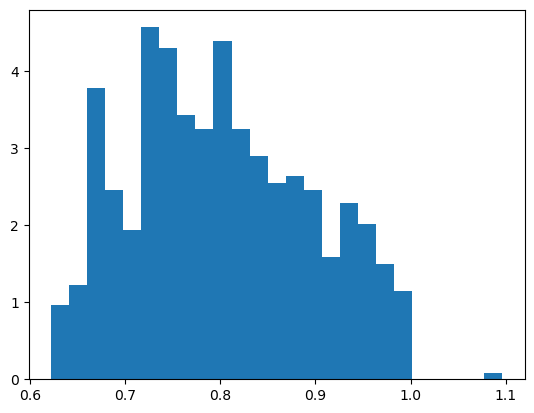

In [374]:
plt.figure()
plt.hist(vals.numpy(), density=True, bins=25)
plt.show()

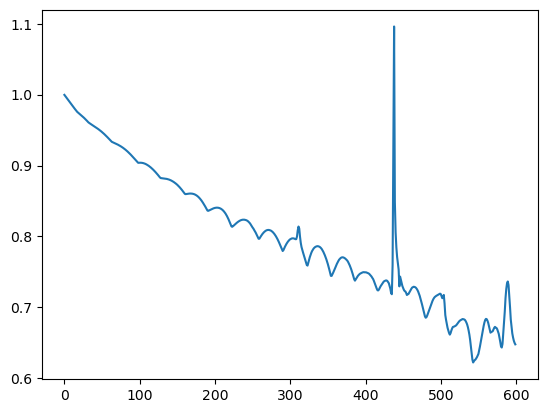

In [375]:
plt.figure()
plt.plot(vals.numpy())
plt.show()

## Check the causaliy of the signal

In [376]:
evens = [i for i in range(x.shape[1]) if i%2 == 0]
odds = [i for i in range(x.shape[1]) if i%2 != 0]
print("Even indices length: ", len(evens))
print("Odd indices length: ", len(odds))

Even indices length:  3
Odd indices length:  3


In [377]:
x_complex = torch.complex(x[:,evens,:], x[:,odds,:])
print("Complex x shape: ", x_complex.shape)

Complex x shape:  torch.Size([1, 3, 600])


In [378]:
x_time = torch.fft.irfft(x_complex, n=2*x_complex.shape[-1]-1, norm="forward")
print("Time-domain x shape: ", x_time.shape)

Time-domain x shape:  torch.Size([1, 3, 1199])


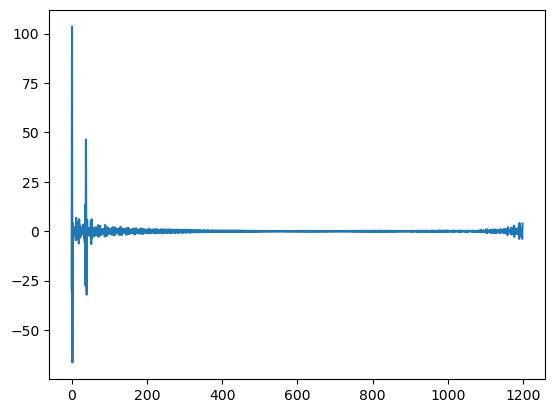

In [379]:
plt.figure()
plt.plot(x_time.cpu().numpy()[0,0,:])
plt.show()

## Try to check the Causality Layer

In [380]:
from model_parts import CausalityLayer

Causal_Layer = CausalityLayer(LENGTH, K=1)
causal_check = Causal_Layer(x[:,evens,:])

In [381]:
print("X shape: ", x.shape)
print("Causal output shape: ", causal_check.shape)

X shape:  torch.Size([1, 6, 600])
Causal output shape:  torch.Size([1, 6, 600])


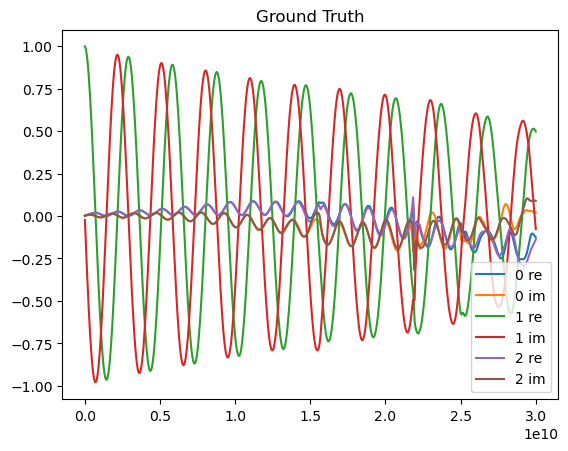

In [382]:
plt.figure()
for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        plt.plot(gt_freqs, x[j,i,:].flatten(), label=label)
plt.title("Ground Truth")
if n_sparams <= 10:
    plt.legend()
plt.show()

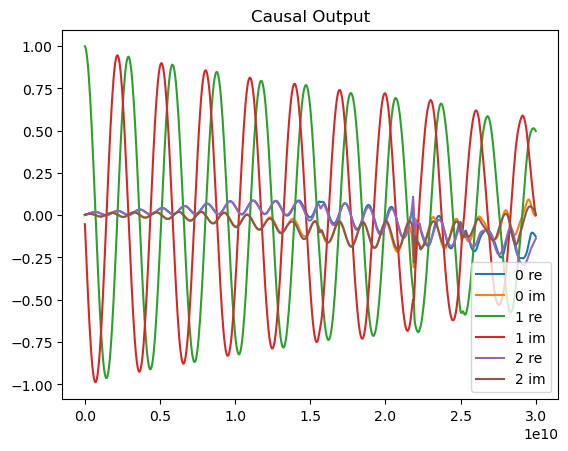

In [383]:
plt.figure()
for j in range(causal_check.shape[0]):
    for i in range(causal_check.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        plt.plot(gt_freqs, causal_check[j,i,:].flatten(), label=label)
plt.title("Causal Output")
if n_sparams <= 10:
    plt.legend()
plt.show()

In [384]:
print("MSE between X and causal recon (should be close to 0): ", torch.mean(torch.square(x - causal_check)).item())

MSE between X and causal recon (should be close to 0):  0.00014433442265726626


In [385]:
x_mag = utils.to_mag(x)
causal_mag = utils.to_mag(causal_check)

print("X magnitude shape: ", x_mag.shape)
print("Causal recon magnitude shape: ", causal_mag.shape)

X magnitude shape:  torch.Size([3, 600])
Causal recon magnitude shape:  torch.Size([3, 600])


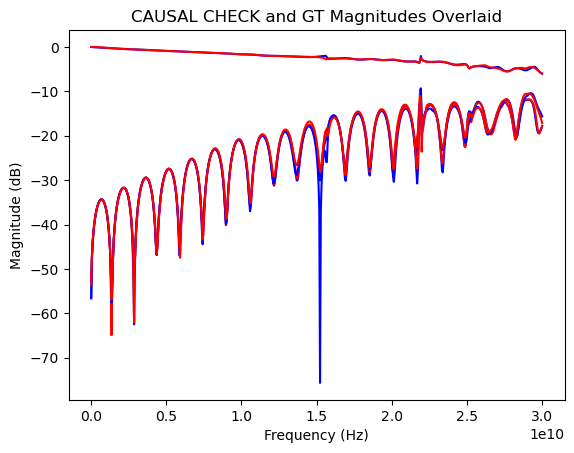

In [386]:
plt.figure()

for i in range(x_mag.shape[0]):
    plt.plot(gt_freqs, x_mag[i], color="blue")
    plt.plot(gt_freqs, causal_mag[i], color="red")

plt.title("CAUSAL CHECK and GT Magnitudes Overlaid")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.show()

## Try to check the passivity layer

### First make sure it doesnt change OG signals

In [387]:
from model_parts import PassivityLayer

Passive_Layer = PassivityLayer()
passive_check = Passive_Layer(x)

In [388]:
print("Passivity recon shape: ", passive_check.shape)
print("MSE between X and passive recon (should be 0): ", torch.mean(torch.square(x - passive_check)).item())

Passivity recon shape:  torch.Size([1, 6, 600])
MSE between X and passive recon (should be 0):  3.109105591647676e-06


### Now scale the OG signal, try to make passive, and compare

In [389]:
x_scaled = 2. * x

In [390]:
print("MSE between X and scaled X: ", torch.mean(torch.square(x - x_scaled)).item())

MSE between X and scaled X:  0.10502103716135025


In [391]:
scaled_vals = utils.sparams_to_sing_vals(x_scaled)
scaled_vals = scaled_vals[:, 0] #grab only the largest singular value

In [392]:
print("Max singular value of scaled X: ", torch.max(scaled_vals).item())
print("Min singular value of scaled X: ", torch.min(scaled_vals).item())

Max singular value of scaled X:  2.192354202270508
Min singular value of scaled X:  1.2445601224899292


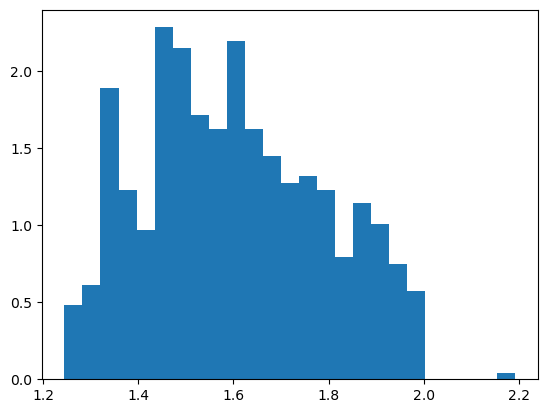

In [393]:
plt.figure()
plt.hist(scaled_vals.numpy(), density=True, bins=25)
plt.show()

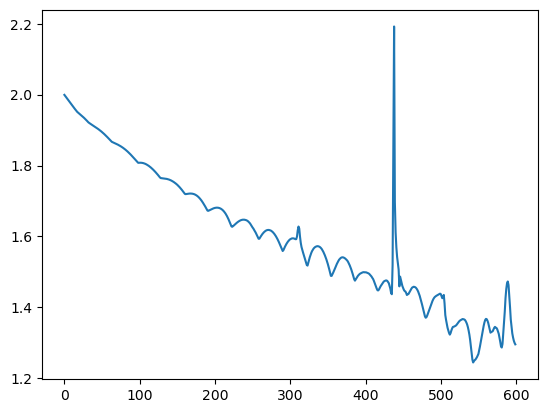

In [394]:
plt.figure()
plt.plot(scaled_vals.numpy())
plt.show()

In [395]:
passive_check = Passive_Layer(x_scaled)

print("Passive recon shape: ", passive_check.shape)
print("MSE between X and passive recon (should be 0): ", torch.mean(torch.square(x - passive_check)).item())

Passive recon shape:  torch.Size([1, 6, 600])
MSE between X and passive recon (should be 0):  0.009439424611628056


In [396]:
passive_vals = utils.sparams_to_sing_vals(passive_check)
passive_vals = passive_vals[:, 0] #grab only the largest singular value

In [397]:
print("Max singular val of passive recon: ", torch.max(passive_vals).item())
print("Min singular val of passive recon: ", torch.min(passive_vals).item())

Max singular val of passive recon:  1.0000003576278687
Min singular val of passive recon:  0.9999996423721313


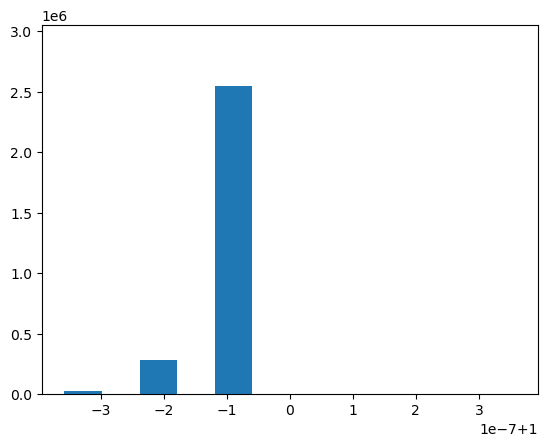

In [398]:
plt.figure()
plt.hist(passive_vals.numpy(), density=True, bins=25)
plt.show()

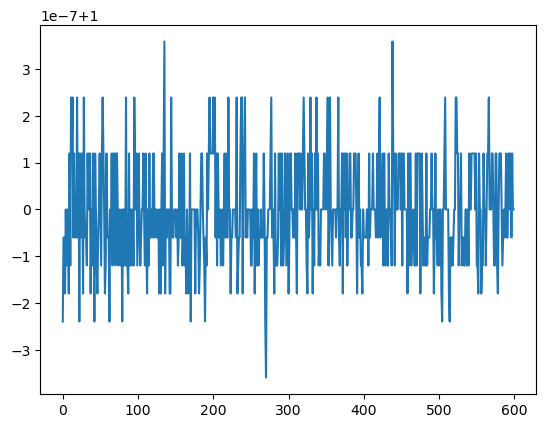

In [399]:
plt.figure()
plt.plot(passive_vals.numpy())
plt.show()

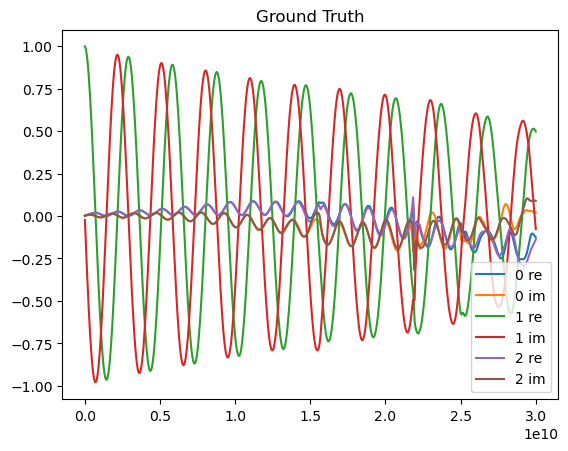

In [400]:
plt.figure()
for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        plt.plot(gt_freqs, x[j,i,:].flatten(), label=label)
plt.title("Ground Truth")
if n_sparams <= 10:
    plt.legend()
plt.show()

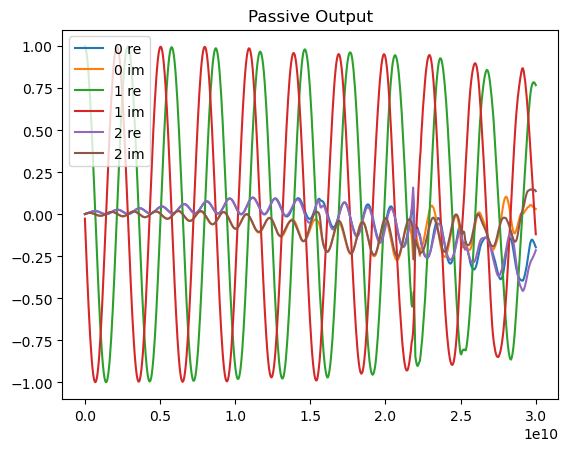

In [401]:
plt.figure()
for j in range(passive_check.shape[0]):
    for i in range(passive_check.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        plt.plot(gt_freqs, passive_check[j,i,:].flatten(), label=label)
plt.title("Passive Output")
if n_sparams <= 10:
    plt.legend()
plt.show()

In [402]:
x_mag = utils.to_mag(x)
passive_mag = utils.to_mag(passive_check)

print("X mag shape", x_mag.shape)
print("Passive recon mag shape", passive_mag.shape)

X mag shape torch.Size([3, 600])
Passive recon mag shape torch.Size([3, 600])


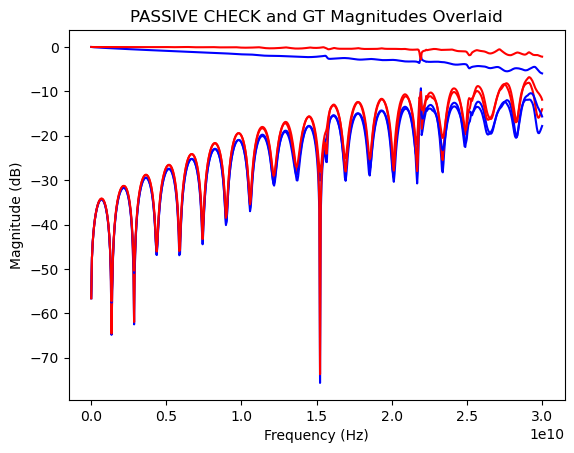

In [403]:
plt.figure()

for i in range(x_mag.shape[0]):
    plt.plot(gt_freqs, x_mag[i], color="blue")
    plt.plot(gt_freqs, passive_mag[i], color="red")

plt.title("PASSIVE CHECK and GT Magnitudes Overlaid")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.show()

# Set up the network

In [404]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(LENGTH))) - 4

BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) if NZ < 64 else NZ
BASE_NGF = max(BASE_NGF, 32)
BASE_NGF = min(BASE_NGF, 512)

NGF = [int(BASE_NGF * 2**(i)) for i in range(NUM_LAYERS)]

BS = y.shape[0]
NC = y.shape[1]

In [405]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)

NZ:  6
NUM_LAYERS:  6
BASE NGF:  32
NGF:  [32, 64, 128, 256, 512, 1024]
BS:  1
NC:  6


In [406]:
from models import RES_UNET

KERNEL_SIZE = 1
USE_SKIP = False
USE_CAUSAL_PASSIVE = True

net = RES_UNET(bs=BS, nz=NZ, ngf=NGF, output_size=LENGTH, nc=NC, kernel_size=KERNEL_SIZE, \
               num_layers=NUM_LAYERS, use_skip=USE_SKIP, causal_passive=USE_CAUSAL_PASSIVE)
net = net.to(device)

In [407]:
test_out = net.forward_with_z()
print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 6, 600])


In [408]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  3843474


In [409]:
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name + ": ", param.shape)

encoder.0.input_layer.0.weight:  torch.Size([32, 6, 1])
encoder.0.input_layer.3.weight:  torch.Size([32, 32, 1])
encoder.1.conv_block.2.weight:  torch.Size([64, 32, 1])
encoder.1.conv_block.6.weight:  torch.Size([64, 64, 1])
encoder.2.conv_block.2.weight:  torch.Size([128, 64, 1])
encoder.2.conv_block.6.weight:  torch.Size([128, 128, 1])
encoder.3.conv_block.2.weight:  torch.Size([256, 128, 1])
encoder.3.conv_block.6.weight:  torch.Size([256, 256, 1])
encoder.4.conv_block.2.weight:  torch.Size([512, 256, 1])
encoder.4.conv_block.6.weight:  torch.Size([512, 512, 1])
decoder.0.conv_block.2.weight:  torch.Size([32, 64, 1])
decoder.0.conv_block.5.weight:  torch.Size([32, 32, 1])
decoder.1.conv_block.2.weight:  torch.Size([64, 128, 1])
decoder.1.conv_block.5.weight:  torch.Size([64, 64, 1])
decoder.2.conv_block.2.weight:  torch.Size([128, 256, 1])
decoder.2.conv_block.5.weight:  torch.Size([128, 128, 1])
decoder.3.conv_block.2.weight:  torch.Size([256, 512, 1])
decoder.3.conv_block.5.weight

# Make the linear interpolation

In [410]:
import scipy

y_np = y.cpu().detach().numpy()

Interpolate = scipy.interpolate.interp1d(kept_inds, y_np, fill_value='extrapolate')

In [411]:
y_interp = Interpolate(np.arange(LENGTH))
y_interp = torch.from_numpy(y_interp)
y_interp = y_interp.to(device)

print("Interpolation shape: ", y_interp.shape)

Interpolation shape:  torch.Size([1, 6, 600])


In [412]:
y_interp_mag = utils.to_mag(y_interp)

print("Interpolation magnitude shape: ", y_interp_mag.shape)

Interpolation magnitude shape:  torch.Size([3, 600])


In [413]:
x_mag = utils.to_mag(x)
y_mag = utils.to_mag(y)

print("X magnitude shape: ", x_mag.shape)
print("Y magnitude shape: ", y_mag.shape)

X magnitude shape:  torch.Size([3, 600])
Y magnitude shape:  torch.Size([3, 8])


In [414]:
# net.set_z(vf_data)
net.set_z(y_interp)

# Run

In [415]:
#grab the correct file we want for VF
chip_num_str = str(chip_num) if chip_num > 9 else "0" + str(chip_num)
folder_pth = os.path.join(root_path, "case"+chip_num_str)
children = os.listdir(folder_pth)
net_str = chip_num_str + ".s"
children = [f for f in children if net_str in f][0]
filename = os.path.join(folder_pth, children)
NUM_ACTIVE = 3

tic = time.time()
for num_actively_sampled in range(NUM_ACTIVE + 1):

    LR = 1e-4 # learning rate
    NUM_ITER = 1000 # number iterations
    if num_actively_sampled == 0: 
        NUM_ITER *= 10

    criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=True, reduction="sum")
    criterion = criterion.to(device)

    REG_HYPERPARAM = 0.1

    if REG_HYPERPARAM > 0:
        regularizer = utils.Smoothing_Loss(per_param=True, reduction="sum")
        regularizer = regularizer.to(device)
        
    net = net.train()

    optim = torch.optim.Adam(net.parameters(), lr=LR)

    train_losses = []
    train_errors = []
    if REG_HYPERPARAM > 0:
        train_regs = []

    test_mses = []
    test_maes = []

    x = x.to(device)
    y = y.to(device)


    # Run DIP with current samples
    for i in range(NUM_ITER):
        optim.zero_grad()
        
        # out = net.forward_with_z()
        out = net.forward_with_z(0.1*(NUM_ITER-i)/NUM_ITER)
        
        train_error = criterion(out, y) 
        if REG_HYPERPARAM > 0:
            train_reg = REG_HYPERPARAM * regularizer(out)
            train_loss = train_error + train_reg
        else:
            train_loss = train_error
        
        train_loss.backward()
        optim.step()
        
        with torch.no_grad():
            train_losses.append(train_loss.item())
            train_errors.append(train_error.item())
            if REG_HYPERPARAM > 0:
                train_regs.append(train_reg.item())
            
            test_mse = nn.MSELoss()(out, x)
            test_mses.append(test_mse.item())
            
            test_mae = nn.L1Loss()(out, x)
            test_maes.append(test_mae.item())
    
    # Run VF with current samples
    fitter = vectorfit.VectorFitter(filename, verbose=False)
    cur_fit = fitter.vector_fit("Current fit", fitter.ground_truth.f[kept_inds])

    # Compare VF and DIP to each other, see where they disagree the most, and then sample and update kept_inds
    #    1. Get the VF values
    vf_cur_output_raw = cur_fit.fitted_network.s
    vf_cur_output = np.stack((vf_cur_output_raw.real, vf_cur_output_raw.imag), axis=-1)
    vf_cur_output = utils.matrix_to_sparams(vf_cur_output)
    vf_cur_output = torch.tensor(vf_cur_output).view(1, -1, LENGTH)
    vf_cur_output = vf_cur_output.to(device)

    def find_max_disagreement(vf_output, dip_output):
        print(torch.argmax(torch.sum(torch.square(vf_output - dip_output), dim=1), dim=1))
        return torch.argmax(torch.sum(torch.square(vf_output - dip_output), dim=1), dim=1).item()   

    # print(out.shape)
    # print(vf_cur_output.shape)
    max_disagree_idx = find_max_disagreement(vf_cur_output, out)
    kept_inds = np.sort(kept_inds if max_disagree_idx in kept_inds else np.append(kept_inds, max_disagree_idx))
    # print(kept_inds)
    # print(kept_inds.shape)

    # Recreate the y data with the new kept_inds
    y = torch.clone(x)[:, :, kept_inds]
    y_freqs = gt_freqs[kept_inds]

    y_np = y.cpu().detach().numpy()
    Interpolate = scipy.interpolate.interp1d(kept_inds, y_np, fill_value='extrapolate')
    y_interp = Interpolate(np.arange(LENGTH))
    y_interp = torch.from_numpy(y_interp)
    y_interp = y_interp.to(device)

    y_interp_mag = utils.to_mag(y_interp)
    x_mag = utils.to_mag(x)
    y_mag = utils.to_mag(y)
    net.set_z(y_interp)

    toc = time.time()
    print("ITER ", str(num_actively_sampled))
    print("TIME: ", str(toc - tic))



tensor([118], device='cuda:1')
ITER  0
TIME:  238.8571183681488
tensor([145], device='cuda:1')
ITER  1
TIME:  262.72068905830383


/scratch/cluster/vgorti/miniconda3/envs/DIP/lib/python3.9/site-packages/skrf/vectorFitting.py:869: RuntimeWarning: invalid value encountered in sqrt
  for sqrt_eigenval in np.sqrt(P_eigs):


tensor([217], device='cuda:1')
ITER  2
TIME:  286.6940224170685
tensor([241], device='cuda:1')
ITER  3
TIME:  310.6317355632782


# Plot the last output and the metrics

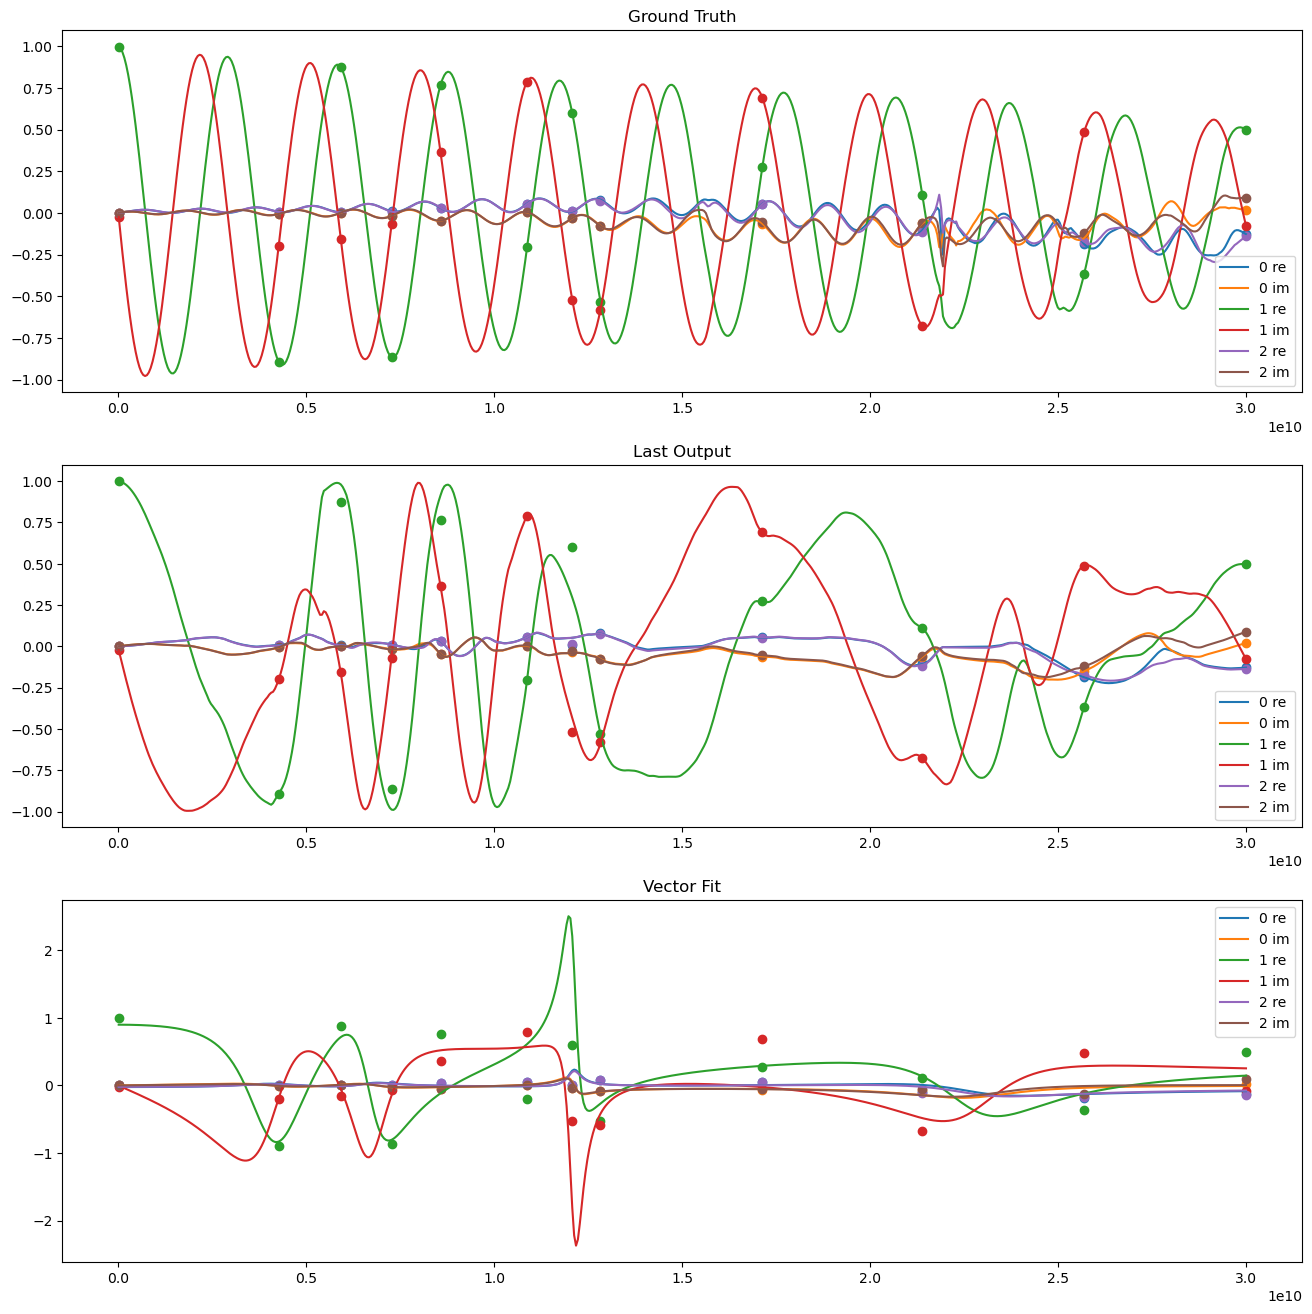

In [416]:
out = out.detach().clone().cpu()

fig, axes = plt.subplots(3,1, figsize=(16, 16))
axes = axes.flatten()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[0].plot(gt_freqs, x[j,i,:].cpu().flatten(), label=label)
        axes[0].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[0].set_title("Ground Truth")
if n_sparams <= 10:
    axes[0].legend()

for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[1].plot(gt_freqs, out[j,i,:].flatten(), label=label)
        axes[1].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[1].set_title("Last Output")
if n_sparams <= 10:
    axes[1].legend()

# for j in range(x.shape[0]):
#     for i in range(x.shape[1]):
#         label = str(i//2) + (" re" if i % 2 == 0 else " im")
#         axes[2].plot(gt_freqs[kept_inds], y[j,i,:].cpu().flatten(), label=label)
# #         axes[2].scatter(gt_freqs[kept_inds], y[j,i].cpu())
# axes[2].set_title("Measurements - Linear interpolation")
# if n_sparams <= 10:
#     axes[2].legend()
    
for j in range(x.shape[0]):
    for i in range(x.shape[1]):
        label = str(i//2) + (" re" if i % 2 == 0 else " im")
        axes[2].plot(gt_freqs, vf_cur_output[j,i,:].cpu().flatten(), label=label)
        axes[2].scatter(gt_freqs[kept_inds], y[j,i].cpu())
axes[2].set_title("Vector Fit")
if n_sparams <= 10:
    axes[2].legend()

plt.show()

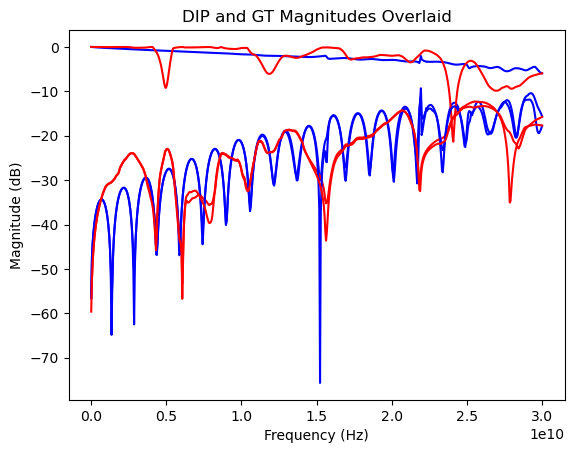

In [417]:
out_mag = utils.to_mag(out)
plt.figure()

for i in range(x_mag.shape[0]):
    plt.plot(gt_freqs, x_mag[i], color="blue")
    plt.plot(gt_freqs, out_mag[i], color="red")

plt.title("DIP and GT Magnitudes Overlaid")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.show()

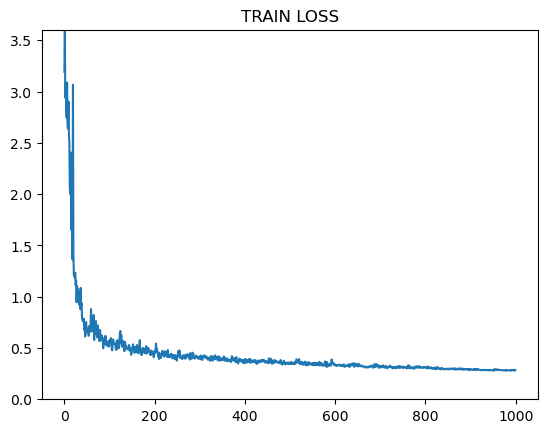

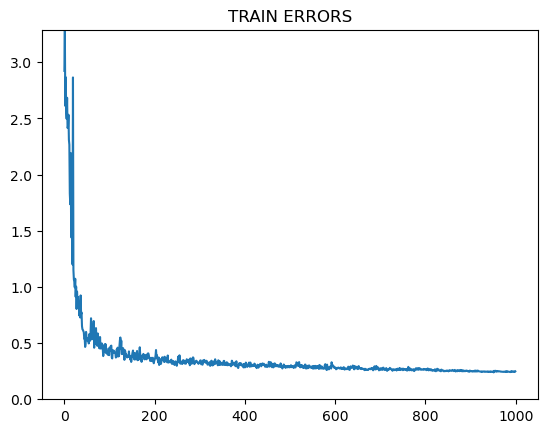

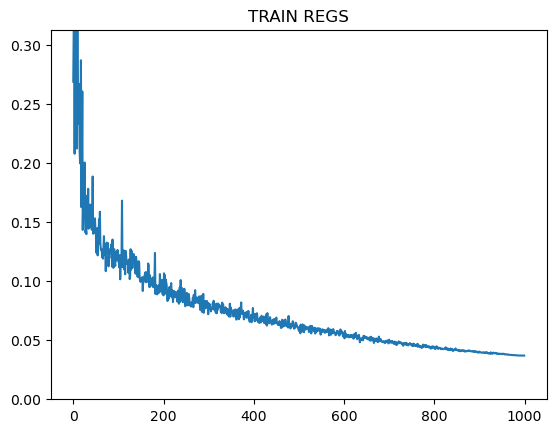

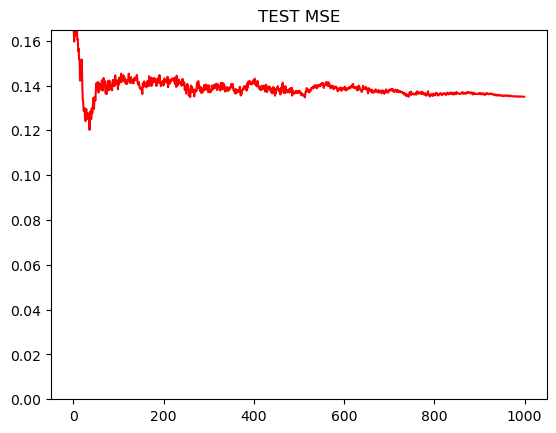

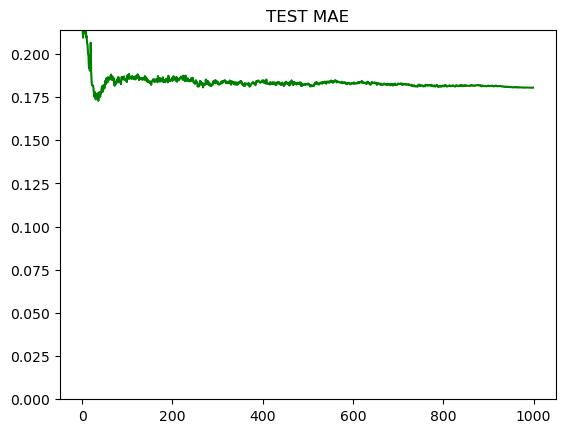

In [418]:
max_idx = np.argmax(train_losses)

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

if REG_HYPERPARAM > 0:
    plt.figure()
    plt.plot(train_regs)
    plt.title("TRAIN REGS")
    plt.ylim(0., train_regs[max_idx])
    plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

# Calculate Metrics between DIP, Vector Fit, Linear Interpolation, and the Ground Truth 

In [419]:
print("FINAL DIP MSE: ", test_mses[-1])
print("LINEAR INTERP MSE: ", torch.nn.MSELoss()(x, y_interp).item())
print("VF MSE: ", torch.nn.MSELoss()(x, vf_cur_output).item())

FINAL DIP MSE:  0.13499034941196442
LINEAR INTERP MSE:  0.1102098736316903
VF MSE:  0.12853044271469116


## Make neworks from DIP, Interp, and Observations

In [420]:
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)

INTERP_MATRIX = utils.sparams_to_matrix(y_interp)

VF_MATRIX = utils.sparams_to_matrix(vf_data)

Y_MATRIX = utils.sparams_to_matrix(y)

AttributeError: 'numpy.ndarray' object has no attribute 'device'

In [ ]:
print(DIP_OUT_MATRIX.shape)
print(INTERP_MATRIX.shape)
print(VF_MATRIX.shape)
print(Y_MATRIX.shape)

In [ ]:
DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(chip_num))

INTERP_net = utils.matrix_to_network(INTERP_MATRIX, gt_freqs, "Linear Interpolation With "+str(M)+" Samples for Chip "+str(chip_num))

VF_net = utils.matrix_to_network(VF_MATRIX, gt_freqs, "Vector Fit With "+str(M)+" Samples for Chip "+str(chip_num))

Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(chip_num))

## Quickly check the singular values of the output

In [ ]:
temp = DIP_net.s

print(temp.shape)
print(temp.dtype)

In [ ]:
vals = np.linalg.svd(temp, compute_uv=False)
print(vals.shape)

In [ ]:
vals = vals[:,0]
print(vals.shape)

In [ ]:
print(np.amax(vals))
print(np.amin(vals))

In [ ]:
plt.figure()
plt.hist(vals, density=True, bins=25)
plt.show

In [ ]:
plt.figure()
plt.plot(vals)
plt.show()

## Grab the data back from the networks for DIP and Interp to compare metrics

In [ ]:
DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)

INTERP_FINAL_OUT = np.stack((INTERP_net.s.real, INTERP_net.s.imag), axis=-1)

VF_FINAL_OUT = np.stack((VF_net.s.real, VF_net.s.imag), axis=-1)

In [ ]:
print(DIP_FINAL_OUT.shape)
print(INTERP_FINAL_OUT.shape)
print(VF_FINAL_OUT.shape)

In [ ]:
dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
interp_data = utils.matrix_to_sparams(INTERP_FINAL_OUT)
vf_data = utils.matrix_to_sparams(VF_FINAL_OUT)

In [ ]:
print(dip_data.shape)
print(interp_data.shape)
print(vf_data.shape)

In [ ]:
print(dip_data.dtype)
print(interp_data.dtype)
print(vf_data.dtype)

## Compare DIP, VF, and Interp

In [ ]:
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_ours = psnr(gt_data, dip_data)
psnr_interp = psnr(gt_data, interp_data)
psnr_vf = psnr(gt_data, vf_data)

In [ ]:
print("DIP PSNR: ", psnr_ours)
print("INTERP PSNR: ", psnr_interp)
print("VF PSNR: ", psnr_vf)

## Save the outputs

In [ ]:
# write_path = "/scratch1/04703/sravula"

# DIP_net.write_touchstone(write_path+"/DIP_"+str(chip_num))
# INTERP_net.write_touchstone(write_path+"/INTERP_"+str(chip_num))
# VF_net.write_touchstone(write_path+"/VF_"+str(chip_num))
# Y_net.write_touchstone(write_path+"/OBSERVATIONS_"+str(chip_num))